In [1]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from torch.utils.tensorboard import SummaryWriter
import time
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
datasetCsv = pd.read_csv('dataset.csv')
# drop id column because it can't be a feature to train
datasetCsv.drop(columns=["Id"], axis= 1, inplace=True)
#replace zeros with NaN 
fields_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in fields_with_invalid_zeros:
    datasetCsv[col] = datasetCsv[col].apply(lambda x: np.nan if x == 0 else x)

#impute values
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(datasetCsv), columns=datasetCsv.columns)

#normalize feature columns (excluding the target)
X = df_imputed.drop(columns=['Outcome'])
y = df_imputed['Outcome']
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#combine features and label into one DataFrame
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

preprocessed_df = pd.DataFrame(X_resampled, columns=X.columns)
preprocessed_df['Outcome'] = y_resampled


device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
writer = SummaryWriter(log_dir=f"runs/experiment_1")
class CustomDataset(Dataset):
    def __init__(self, dataFrane):
        self.data = dataFrane
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        features = torch.tensor(row[:-1].values, dtype=torch.float32)
        label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]
        return features, label
    
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
def train(dataLoader, model, loss_fn, optimizer, epoch, writer):
        size = len(dataLoader.dataset)
        model.train() #set model to the training mode, it just switches internal setting
        running_loss = 0.0
        correct = 0
        for batch, (X, y) in enumerate(dataLoader):
            X, y = X.to(device), y.to(device)
            predict = model(X)
            loss = loss_fn(predict, y)
            #backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() #?
            # Calculate accuracy for this batch
            pred_binary = (predict >= 0.5).float()
            correct += (pred_binary == y).sum().item()
            running_loss += loss.item()
            
            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # Log training metrics to TensorBoard
        avg_loss = running_loss / len(dataLoader)
        accuracy = (correct / size) * 100
        
        writer.add_scalar('Loss/Train', avg_loss, epoch)
        writer.add_scalar('Accuracy/Train', accuracy, epoch)
                
def test(dataloader, model, loss_fn, epoch, writer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = pred.flatten()
            y = y.flatten()
            for i in range(len(pred)):
                predict = 1 if pred[i] >= 0.5 else 0
                if predict == y[i]:
                   correct += 1 
    test_loss /= num_batches
    correct /= size
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', correct, epoch)
    print(f"Accuracy: {correct}%, Avg loss: {test_loss:>8f} \n")
    return correct
    
    
customDataset = CustomDataset(preprocessed_df)

trainData, testData = random_split(customDataset, [0.8, 0.2])
print(len(trainData))
print(len(testData))
trainDataLoader = DataLoader(trainData, batch_size=64, shuffle=True)
testDataLoader = DataLoader(testData, batch_size=64, shuffle=False)
model = NeuralNetwork().to(device)
loss_fn = nn.BCELoss() # use binary cross entropy because we have 2 classes in target
optimizer = torch.optim.SGD(model.parameters(), lr= 0.1) #??? changed SGD to adam

epochs = 20
for i in range(epochs):
    print(f'Epoch {i + 1}')
    train(trainDataLoader, model, loss_fn, optimizer, i, writer)
    test(testDataLoader, model, loss_fn, i, writer)
writer.close()
print("DONE!")

2906
726
Epoch 1
loss: 0.656044  [   64/ 2906]


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_4415/321213032.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Accuracy: 0.7713498622589532%, Avg loss: 0.514430 

Epoch 2
loss: 0.520660  [   64/ 2906]
Accuracy: 0.7878787878787878%, Avg loss: 0.471202 

Epoch 3
loss: 0.435110  [   64/ 2906]
Accuracy: 0.7892561983471075%, Avg loss: 0.454782 

Epoch 4
loss: 0.568514  [   64/ 2906]
Accuracy: 0.7892561983471075%, Avg loss: 0.444061 

Epoch 5
loss: 0.400519  [   64/ 2906]
Accuracy: 0.7851239669421488%, Avg loss: 0.438486 

Epoch 6
loss: 0.492533  [   64/ 2906]
Accuracy: 0.7851239669421488%, Avg loss: 0.434268 

Epoch 7
loss: 0.426101  [   64/ 2906]
Accuracy: 0.7975206611570248%, Avg loss: 0.431569 

Epoch 8
loss: 0.528951  [   64/ 2906]
Accuracy: 0.7988980716253443%, Avg loss: 0.426967 

Epoch 9
loss: 0.523290  [   64/ 2906]
Accuracy: 0.7988980716253443%, Avg loss: 0.424634 

Epoch 10
loss: 0.466374  [   64/ 2906]
Accuracy: 0.8057851239669421%, Avg loss: 0.422360 

Epoch 11
loss: 0.409606  [   64/ 2906]
Accuracy: 0.803030303030303%, Avg loss: 0.419841 

Epoch 12
loss: 0.458662  [   64/ 2906]
Accuracy

In [4]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 4878), started 0:00:02 ago. (Use '!kill 4878' to kill it.)

In [30]:
# Re-run everything after kernel reset
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load dataset
datasetCsv = pd.read_csv("dataset.csv")

# Drop ID column
datasetCsv.drop(columns=["Id"], axis=1, inplace=True)

# Replace zero with NaN for selected medical fields
fields_with_invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in fields_with_invalid_zeros:
    datasetCsv[col] = datasetCsv[col].apply(lambda x: np.nan if x == 0 else x)

# Impute missing values using median
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(datasetCsv), columns=datasetCsv.columns)

# Separate features and target
X = df_imputed.drop(columns=['Outcome'])
y = df_imputed['Outcome']

# Normalize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Recover original age values before scaling
age_mean = df_imputed['Age'].mean()
age_std = df_imputed['Age'].std()
ages_unscaled = X_resampled['Age'] * age_std + age_mean

# Assign age groups
def age_group(age):
    if age < 30:
        return 'Under 30'
    elif 30 <= age <= 50:
        return '30–50'
    else:
        return 'Over 50'

age_groups = pd.Series(ages_unscaled).apply(age_group)

# Create final processed DataFrame with AgeGroup and Outcome
processed_df = pd.DataFrame(X_resampled, columns=X.columns)
processed_df['AgeGroup'] = age_groups
processed_df['Outcome'] = y_resampled

In [46]:
# Filter data for people over 50 years old
over_50_data = processed_df[processed_df['AgeGroup'] == 'Over 50']

print(f"Total samples: {len(processed_df)}")
print(f"Samples over 50: {len(over_50_data)}")
print(f"Percentage over 50: {len(over_50_data)/len(processed_df)*100:.2f}%")

# Check the outcome distribution for over 50 group
outcome_distribution = over_50_data['Outcome'].value_counts()
print(f"\nOutcome distribution for Over 50 group:")
print(f"Non-diabetic (0): {outcome_distribution[0]} ({outcome_distribution[0]/len(over_50_data)*100:.2f}%)")
print(f"Diabetic (1): {outcome_distribution[1]} ({outcome_distribution[1]/len(over_50_data)*100:.2f}%)")

# Remove AgeGroup column before creating dataset (only keep numerical features and Outcome)
over_50_data_clean = over_50_data.drop(columns=['AgeGroup'])

# Create dataset and dataloader for over 50 data
over_50_dataset = CustomDataset(over_50_data_clean)
over_50_dataloader = DataLoader(over_50_dataset, batch_size=64, shuffle=False)

# Test the model on over 50 data (need to import necessary modules first)
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

print("\nDataset ready for testing on over 50 age group!")
test(over_50_dataloader, model, loss_fn, 0, writer)

Total samples: 3632
Samples over 50: 418
Percentage over 50: 11.51%

Outcome distribution for Over 50 group:
Non-diabetic (0): 163 (39.00%)
Diabetic (1): 255 (61.00%)

Dataset ready for testing on over 50 age group!
Accuracy: 0.7894736842105263%, Avg loss: 0.458751 



/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_4415/321213032.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


0.7894736842105263

In [38]:
# Test the trained model specifically on over 50 data
# Make sure you've run the training cell first to create model, loss_fn, and writer

if 'model' in globals() and 'loss_fn' in globals():
    print("Testing model performance on Over 50 age group:")
    print("=" * 50)
    test(over_50_dataloader, model, loss_fn, 0, writer)
else:
    print("Please run the training cell first to create the model, loss function, and writer variables.")

Testing model performance on Over 50 age group:


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_4415/321213032.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Accuracy: 0.7894736842105263%, Avg loss: 0.458751 



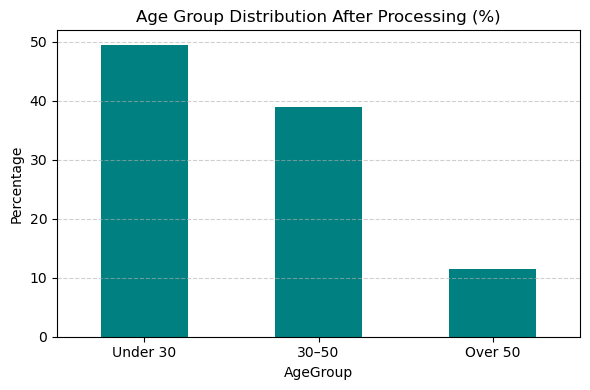

In [31]:
# Plot the percentage distribution of each age group from the processed DataFrame
import matplotlib.pyplot as plt

# Calculate percentage distribution
age_group_percent = processed_df['AgeGroup'].value_counts(normalize=True) * 100

# Plot as bar chart
plt.figure(figsize=(6, 4))
age_group_percent.plot(kind='bar', color='teal')
plt.title("Age Group Distribution After Processing (%)")
plt.ylabel("Percentage")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Test real data

In [54]:
# Load completely raw dataset for testing (no preprocessing at all)
raw_datasetCsv = pd.read_csv('dataset.csv')

# Only drop Id column, keep everything else as is (including zeros and missing values)
raw_datasetCsv = raw_datasetCsv.drop(columns=["Id"], axis=1)

print(f"Raw data shape: {raw_datasetCsv.shape}")
print(f"Raw data columns: {raw_datasetCsv.columns.tolist()}")
print(f"\nFirst few rows of raw data:")
print(raw_datasetCsv.head())

print(f"\nChecking for zeros and missing values:")
for col in raw_datasetCsv.columns:
    zeros = (raw_datasetCsv[col] == 0).sum()
    missing = raw_datasetCsv[col].isnull().sum()
    print(f"{col}: {zeros} zeros, {missing} missing values")

# Create dataset and dataloader with completely raw data
raw_customDataset = CustomDataset(raw_datasetCsv)
rawDataLoader = DataLoader(raw_customDataset, batch_size=64, shuffle=False)

print(f"\nRaw data loaded: {len(raw_customDataset)} samples")
print("Ready to test on completely raw, unprocessed data!")

Raw data shape: (2768, 9)
Raw data columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

First few rows of raw data:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Checking for zeros and missing values:
Pregnancies: 412 zeros, 0 missing values
Glucose: 18 zeros, 0 mis

In [56]:
test(rawDataLoader, model, loss_fn, 0, writer)

/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_4415/321213032.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Accuracy: 0.3504335260115607%, Avg loss: 62.778939 



0.3504335260115607

In [57]:
# Group data by Outcome and test model performance on each class
diabetic_data = processed_df[processed_df['Outcome'] == 1.0]
non_diabetic_data = processed_df[processed_df['Outcome'] == 0.0]

print("="*60)
print("TESTING MODEL PERFORMANCE BY OUTCOME CLASS")
print("="*60)

print(f"Total samples: {len(processed_df)}")
print(f"Diabetic samples (1): {len(diabetic_data)} ({len(diabetic_data)/len(processed_df)*100:.2f}%)")
print(f"Non-diabetic samples (0): {len(non_diabetic_data)} ({len(non_diabetic_data)/len(processed_df)*100:.2f}%)")

# Remove AgeGroup column if it exists
def clean_data_for_testing(data):
    if 'AgeGroup' in data.columns:
        return data.drop(columns=['AgeGroup'])
    return data

# Create datasets and dataloaders for each outcome group
diabetic_data_clean = clean_data_for_testing(diabetic_data)
non_diabetic_data_clean = clean_data_for_testing(non_diabetic_data)

diabetic_dataset = CustomDataset(diabetic_data_clean)
non_diabetic_dataset = CustomDataset(non_diabetic_data_clean)

diabetic_dataloader = DataLoader(diabetic_dataset, batch_size=64, shuffle=False)
non_diabetic_dataloader = DataLoader(non_diabetic_dataset, batch_size=64, shuffle=False)

print("\n" + "="*50)
print("TESTING ON DIABETIC PATIENTS (Outcome = 1)")
print("="*50)
print(f"Testing {len(diabetic_data)} diabetic samples...")
diabetic_accuracy = test(diabetic_dataloader, model, loss_fn, 0, writer)

print("\n" + "="*50)
print("TESTING ON NON-DIABETIC PATIENTS (Outcome = 0)")
print("="*50)
print(f"Testing {len(non_diabetic_data)} non-diabetic samples...")
non_diabetic_accuracy = test(non_diabetic_dataloader, model, loss_fn, 0, writer)

print("\n" + "="*60)
print("SUMMARY OF RESULTS BY OUTCOME CLASS")
print("="*60)
print(f"Diabetic patients accuracy: {diabetic_accuracy:.2%}")
print(f"Non-diabetic patients accuracy: {non_diabetic_accuracy:.2%}")
print(f"Overall difference: {abs(diabetic_accuracy - non_diabetic_accuracy):.2%}")

if diabetic_accuracy > non_diabetic_accuracy:
    print("→ Model performs BETTER on diabetic patients")
else:
    print("→ Model performs BETTER on non-diabetic patients")

TESTING MODEL PERFORMANCE BY OUTCOME CLASS
Total samples: 3632
Diabetic samples (1): 1816 (50.00%)
Non-diabetic samples (0): 1816 (50.00%)

TESTING ON DIABETIC PATIENTS (Outcome = 1)
Testing 1816 diabetic samples...


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_4415/321213032.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = torch.tensor(row[-1], dtype=torch.float32).unsqueeze(0)  # shape [1]


Accuracy: 0.8166299559471366%, Avg loss: 0.441466 


TESTING ON NON-DIABETIC PATIENTS (Outcome = 0)
Testing 1816 non-diabetic samples...
Accuracy: 0.802863436123348%, Avg loss: 0.409316 


SUMMARY OF RESULTS BY OUTCOME CLASS
Diabetic patients accuracy: 81.66%
Non-diabetic patients accuracy: 80.29%
Overall difference: 1.38%
→ Model performs BETTER on diabetic patients
Accuracy: 0.802863436123348%, Avg loss: 0.409316 


SUMMARY OF RESULTS BY OUTCOME CLASS
Diabetic patients accuracy: 81.66%
Non-diabetic patients accuracy: 80.29%
Overall difference: 1.38%
→ Model performs BETTER on diabetic patients
